In [39]:
import os
import pandas as pd
import math
import numpy as np
import requests
from io import StringIO

pd.__version__

'1.3.3'

In [40]:
def gitlab_raw_data(prj_id,prj_file,branch):
    '''
    read remote raw file from gitlab using api
    GET /projects/:id/repository/files/:file_path/raw
    file_path (required) - URL encoded full path to new file, such as lib%2Fclass%2Erb.
    ref (optional) - The name of branch, tag or commit. Default is the HEAD of the project.
    '''
    prj_id_q = requests.utils.quote(prj_id,safe='')
    prj_file_q = requests.utils.quote(prj_file,safe='')
    #data_url = "https://gitlab.advr.iit.it/api/v4/projects/hhmc-firmware%2Fmsp432-ft6/repository/files/calib%2Fsens_2%2Etxt/raw?ref=calib"
    data_url = f"https://gitlab.advr.iit.it/api/v4/projects/{prj_id_q}/repository/files/{prj_file_q}/raw?ref={branch}"
    print(data_url)
    headers = {"PRIVATE-TOKEN": "MCBxyjeT61Bngox7Ktas"}
    return StringIO(requests.get(data_url,headers=headers).text)

In [41]:
#dL=0.044;  # position offset between sensors along z axis for WALKMAN feet
#dL=0.0346; # position offset between sensors along z axis for mini45/50 sensors 
#dL=0.1737; # New setup distance from from mini 45 ATI to the foot sensor.
#dL=0.065;  # New setup distance from from mini 45 ATI to the HERI hand sensor.
dL=0.159;  # New setup distance from from mini 45 ATI to the cogimon foot sensor.
#dL=0.0549; # New setup distance from from mini 45 ATI to the HERI hand sensor for Singapore.


In [42]:
sg_col_names =str.split("sg1 sg2 sg3 sg4 sg5 sg6")
ft_col_names =str.split("fx fy fz tx ty tz")
col_names =["time_ns"]+sg_col_names+ft_col_names
# read local file
data = pd.read_csv("sens.txt", sep="\t", names=col_names)
# read from gitlab
gitlab_file_arg = ("hhmc-firmware/msp432-ft6","calib/sens_1.txt","calib")
#data = pd.read_csv(gitlab_raw_data(*gitlab_file_arg), sep="\t", names=col_names)

#data = pd.DataFrame(np.arange(20).reshape(10,2))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58814 entries, 0 to 58813
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   time_ns  58814 non-null  int64  
 1   sg1      58814 non-null  float64
 2   sg2      58814 non-null  float64
 3   sg3      58814 non-null  float64
 4   sg4      58814 non-null  float64
 5   sg5      58814 non-null  float64
 6   sg6      58814 non-null  float64
 7   fx       58814 non-null  float64
 8   fy       58814 non-null  float64
 9   fz       58814 non-null  float64
 10  tx       58814 non-null  float64
 11  ty       58814 non-null  float64
 12  tz       58814 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 5.8 MB


Prepare data
- SG{i,v} ==> Strain Gauge raw data (sg1, sg2, sg3, sg4, sg5, sg6)
- SGi used for identification of calib matrix, first half samples
- SGv used for verification of calib matrix, seconda half samples
- FT{i,v} ==> ATI Force Torque data (fx, fy, fz, tx, ty, tz)
- FTi used for identification of calib matrix
- FTv used for verification of calib matrix

In [70]:
ign = 10000
drop_idx = True
half_idx = math.ceil(len(data)/2)
_1st_half = data[ign:half_idx]
_2nd_half = data[ign+half_idx:len(data)]
SGi = _1st_half[col_names[1:7]].copy().reset_index(drop=drop_idx)
SGv = _2nd_half[col_names[1:7]].copy().reset_index(drop=drop_idx)
FTi = _1st_half[col_names[7:13]].copy().reset_index(drop=drop_idx)
FTv = _2nd_half[col_names[7:13]].copy().reset_index(drop=drop_idx)
# Map measured ATI Tx,Ty to our sensor frame at distance dL along z axis
# correct Tx torque for the dL    Tx_IIT = Tx_ATI-Fy_ATI*DL
FTi.tx -= FTi.fy*dL
# correct Ty torque for the dL    Ty_IIT = Ty_ATI+Fx_ATI*DL
FTi.ty += FTi.fx*dL
# correct Tx torque for the dL    Tx_IIT = Tx_ATI-Fy_ATI*DL
FTv.tx -= FTv.fy*dL
# correct Ty torque for the dL    Ty_IIT = Ty_ATI+Fx_ATI*DL
FTv.ty += FTv.fx*dL

In [71]:
#SGi_inv = pd.DataFrame(np.linalg.pinv(SGi.values), SGi.columns, SGi.index)
#npSGi_inv = SGi_inv.to_numpy()

npSGi = SGi.to_numpy()
npSGv = SGv.to_numpy()

npSGi_inv = np.linalg.pinv(npSGi)
npFTi = FTi.to_numpy()
npCM = np.dot(npSGi_inv,npFTi)
condCM = np.linalg.cond(npCM)
print(f"CM condition number {condCM}")

npFc= np.dot(npSGv,npCM)
Fc = pd.DataFrame(data=npFc.astype(float),columns=ft_col_names)

# Compute mean square errors
# Fx_residual = Fc(:,1)-FTv(:,1);
F_residual = Fc - FTv


CM condition number 784.4644725905762


In [64]:
#dfCM = pd.DataFrame(data=npCM.T.astype(float))
#dfCM.to_csv('cal_mat.txt', sep=',', header=False, float_format='%.6f', index=False)
#npCM.T.tofile('cal_mat.bin',format='%f')
#np.fromfile('cal_mat.bin')
#np.identity(6, dtype='float32').tofile('ones.bin',format='%f')
#np.fromfile('ones.bin', dtype='float32')

In [65]:
def write_mat_sig(np_mat, filename):
    (name,ext) = os.path.splitext(filename)
    orig_shape = np_mat.shape

    # write txt file
    dfMat = pd.DataFrame(data=np_mat.astype(float))
    dfMat.to_csv(name+'.txt', sep=',', header=False, float_format='%.6f', index=False)
    #np_mat.tofile(name+'.txt', sep=',', format='%.6f')
    
    with open(filename, "wb") as f:
        f.write(bytearray([0xFE,0xCA,0x00,0x00])+np_mat.astype('float32').tobytes())
        #f.write(bytearray([0xFE,0xCA,0x00,0x00]))
        #np_mat.astype('float32').tofile(f)
    # read back 
    with open(filename, "rb") as f:
        np_back = np.fromfile(f,dtype='float32',offset=4).reshape(orig_shape)

    print( np.array_equiv(np_mat,np_back) )
    print(np_back)
    print(f"m shape {orig_shape} {np_back.shape}")
    print(f"m bytes {len(np_back.tobytes())}")

    return np_back      


ret = write_mat_sig(np.identity(6),"ones.bin")
ret = write_mat_sig(npCM.T,"cal_mat.bin")


True
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
m shape (6, 6) (6, 6)
m bytes 144
False
[[-131.05061      59.334663   -113.804565     55.595547     65.71785
    57.782776  ]
 [ 144.61006      21.824938     68.219894    -57.62336    -135.532
   -44.935917  ]
 [ 256.9631     -117.54995     201.85983     -50.592182   -267.16327
   115.61953   ]
 [  -2.8001196   -10.898385      0.39001474  -15.166491     29.053526
     1.9672294 ]
 [  19.994328     17.592138     -6.4501963   -30.99098      -3.0601652
     3.6649737 ]
 [ -12.152808     14.480421    -10.360768     12.229883      7.309893
   -14.274919  ]]
m shape (6, 6) (6, 6)
m bytes 144


<AxesSubplot:>

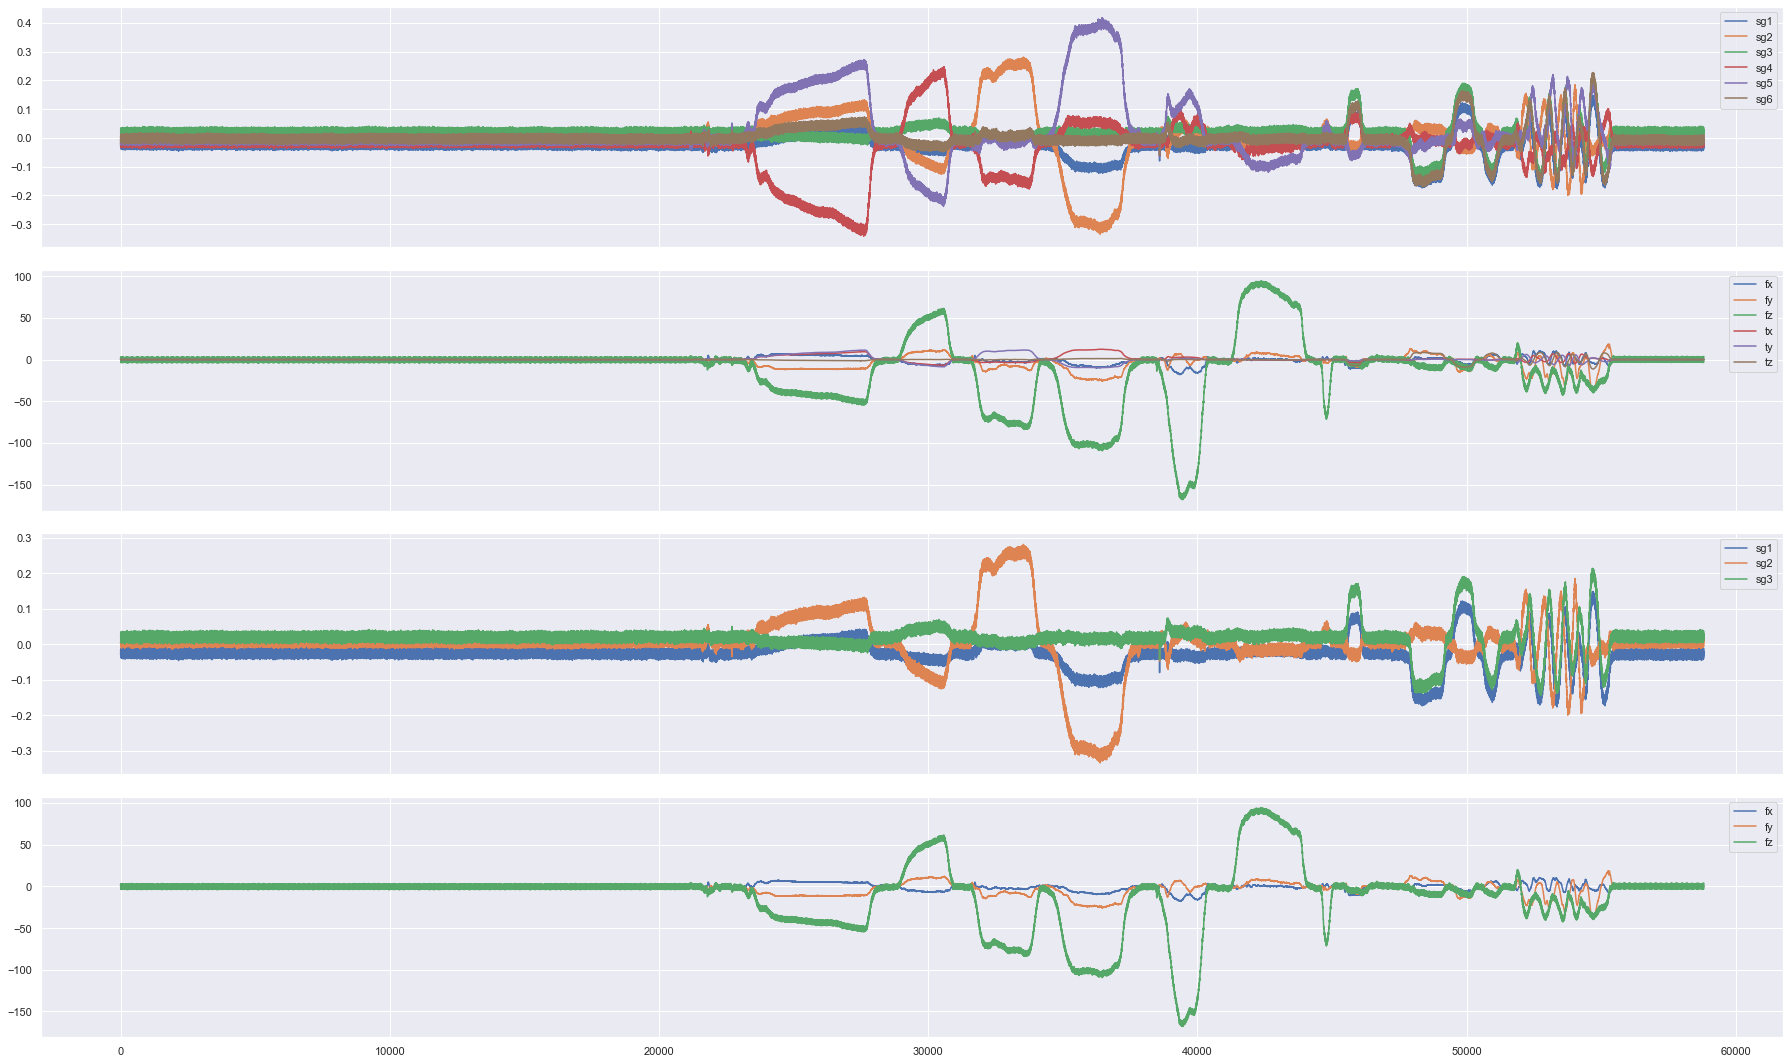

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig, axes = plt.subplots(4,1, sharex='col', figsize=(25,15))
plt.tight_layout()

#data[col_names[1:]].plot(ax=axes[0,0])
data[col_names[1:7]].plot(ax=axes[0])
data[col_names[7:13]].plot(ax=axes[1])
data[col_names[1:4]].plot(ax=axes[2])
data[col_names[7:10]].plot(ax=axes[3])
data[col_names[4:7]].plot(ax=axes[2])
data[col_names[10:13]].plot(ax=axes[3])


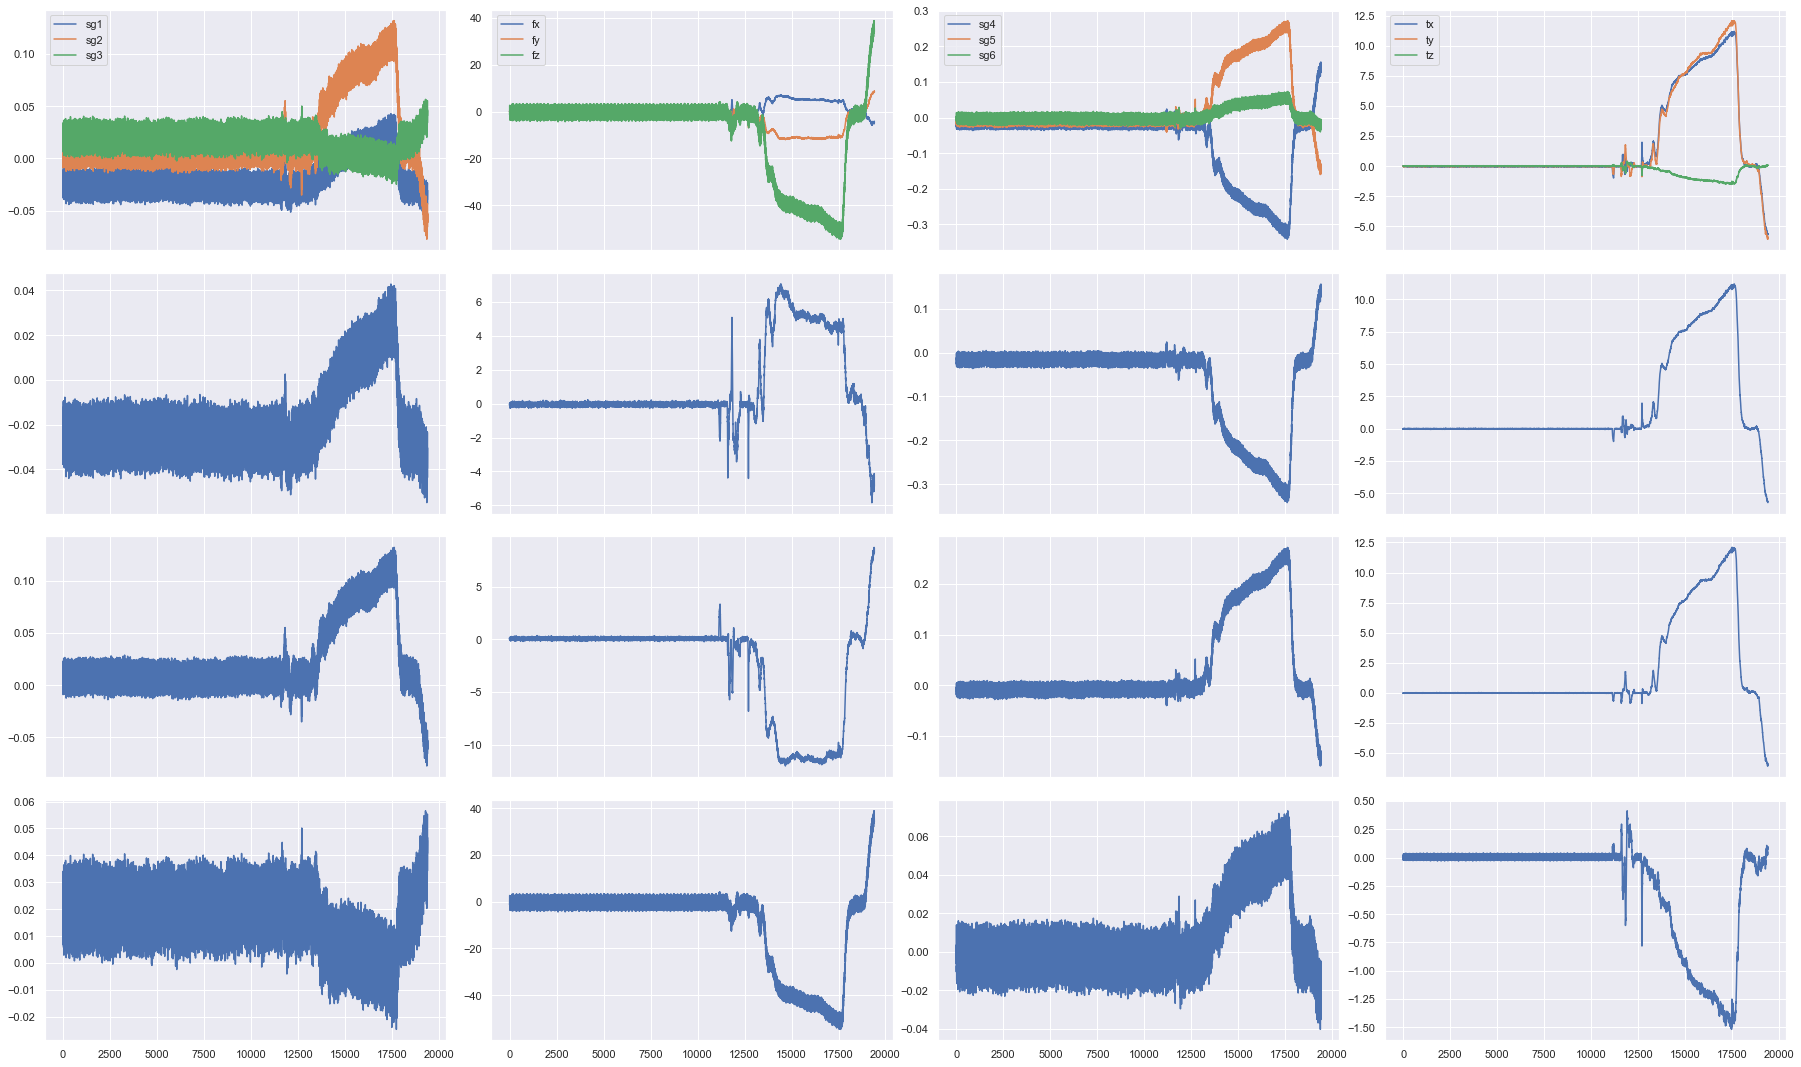

In [67]:
fig, axes = plt.subplots(4,4, sharex='col', figsize=(25,15))
plt.tight_layout()

def plot_data(ax, df, col_names, sub_col):
    df[col_names].plot(ax=axes[0,sub_col])
    for i,c in enumerate(col_names,start=1) :
        df[c].plot(ax=ax[i,sub_col],label=c)
     
plot_data(axes, SGi, sg_col_names[:3],  0)
plot_data(axes, FTi, ft_col_names[:3],  1)
plot_data(axes, SGi, sg_col_names[-3:], 2)
plot_data(axes, FTi, ft_col_names[-3:], 3)

#plot_data(axes, F_residual, ft_col_names[:3], 2)
#plot_data(axes, F_residual, ft_col_names[-3:], 4)
